# 0.0. IMPORTS

In [3]:
import pandas as pd
import inflection
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from scipy import stats

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from boruta import BorutaPy

from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline

## 0.1. Helper Functions

In [4]:
def cramer_v(x,y):
   
    cm = pd.crosstab(x,y).values
    r, k = cm.shape
    n = cm.sum()
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2 /(n-1) 
    rcorr = r - (r-1)**2 /(n-1)
   
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 )))



def mean_absolute_percentage_error(y, yhat):
    return np.abs(np.mean((y - yhat) / y))

def mean_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name,y,yhat):
    
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y , yhat))
    
    return pd.DataFrame({'Model Name': model_name, "MAE": mae,"MAPE": mape,"RMSE": rmse}, index = [0])


def cross_validation(x_training,kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):
        if verbose:           
            print("\nKFold Number: {}".format(k))
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date =  x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)


    #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset

        #training
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance

        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        #store performance of each kfold iteration    
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({"Model Name": model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + " +/- " + np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + " +/- " + np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + " +/- " + np.round(np.std(rmse_list),2).astype(str)}, index = [0])



## 0.2. Loading Data

In [6]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv("data/store.csv", low_memory = False)

#Merge
df_raw = pd.merge(df_sales_raw,df_store_raw,how ='left', on = 'Store')

# 1.0. DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

#rename
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [11]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Como tratar?

- Jogar fora as linhas? Rápido e fácil, porém irá jogar muitos dados fora
- Algoritmos de machine learning - substituir colunas vazias pelo próprio comportamento da coluna(mediana e média, por exemplo) Bom quando não há conceito de negócio
- Entender o negócio - Porque o NA está lá? Houve inputs errados? 

## 1.5. Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)
  
#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
                               
#promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1  if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)


In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

Verificar que, após mudança das variáveis, os tipos podem estar inconsistentes

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)



In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

- útil para compreender o contexto de negócio 
- identificar alguns erros 
- Verificar métricas de dispersão e métricas de tendência central(resumem os dados em um único número)
- Separar as variáveis numéricas e as variáveis categóricas

In [20]:
#Separando as variáveis categóricas das variáveis numéricas
num_attributes = df1.select_dtypes(include = ['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]','int32'])

### 1.7.1 Numerical Attributes

In [21]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range,skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


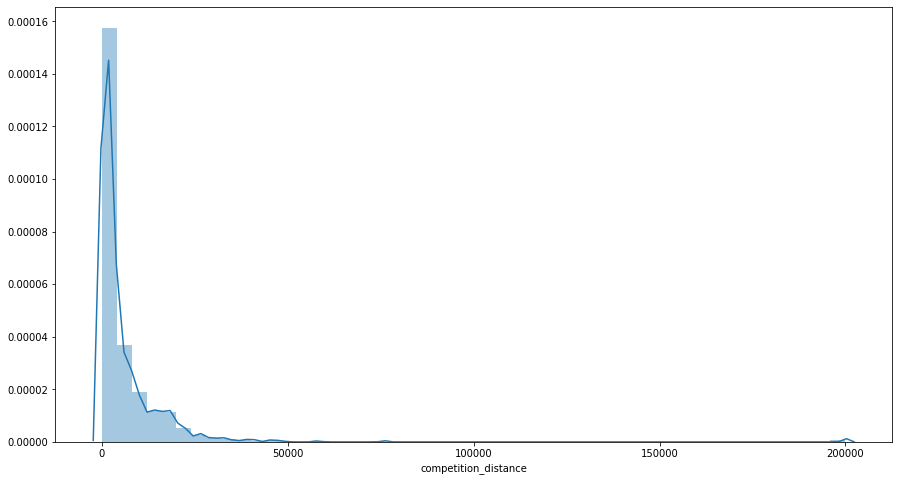

In [22]:
plt.figure(figsize = (15,8))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

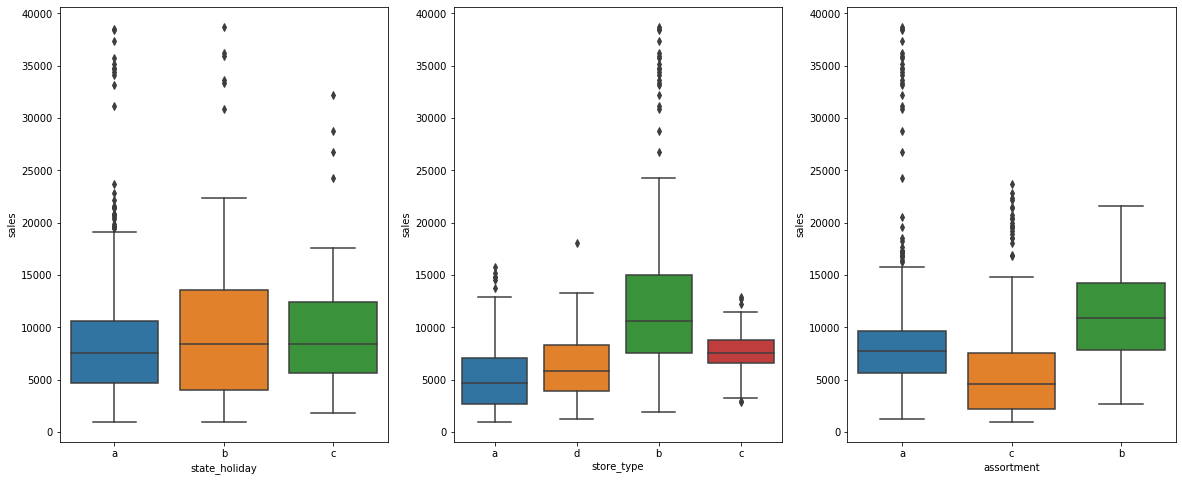

In [24]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize = (20,8))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales' ,data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales' ,data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales' ,data = aux1)

# 2.0. FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses 

In [26]:
Image('img/MindMapHyphotesis.png')

FileNotFoundError: No such file or directory: 'img/MindMapHyphotesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHyphotesis.png'

<IPython.core.display.Image object>

### 2.1.1. Hipóteses da Loja

**1.** Lojas com maior quantidade de funcionário deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender menos.

### 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que Expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produto deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveria vender mais.

**5.** Lojas com promoções mais agressivas, deveriam vender mais.

**6.** Lojas com promoções ativas durante mais tempo deveriam vender mais.

**7.** Lojas com mais dias consecutivos de promoção deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

Para escolher as hipóteses que nós utilizaremos, precisamos verificar se de fato nós possuímos as informações necessárias para tal. Poranto, a partir disso, segue abaixo a lista das hipóteses que utilizaremos.




**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender menos.

    

**4.** Lojas com promoções mais agressivas, deveriam vender mais.

**5.** Lojas com promoções ativas durante mais tempo deveriam vender mais.

**6.** Lojas com mais dias consecutivos de promoção deveriam vender mais.
    

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.
    
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

    

## 2.3. Feature Engineering 

In [27]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of day
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + "-" + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta( days = 7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else "regular_day")

# 3.0. FILTRAGEM DE VARIÁVEIS 

In [28]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [30]:
cols_drop = ['customers','open', 'promo_interval','month_map']
df3 = df3.drop(columns = cols_drop, axis = 1)

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [32]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

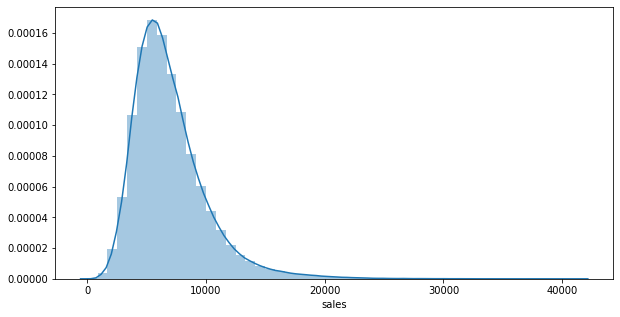

In [33]:
plt.figure(figsize = (10,5))
sns.distplot(df4['sales'])

- formato de sino, kurtosis
- skew mais para esquerda - positiva
- não está centrada, proxima da normal mas não é a normal

- obs = algoritmos de machine learning são criados a partir de alguns comportamentos do espaço dos dados, onde uma das condições é que os dados sejam independentes e que seja normalmente distribuidos. Então, quanto mais normal for sua variável resposta, melhor seu algoritmo irá performar.

### 4.1.2. Numerical Variable

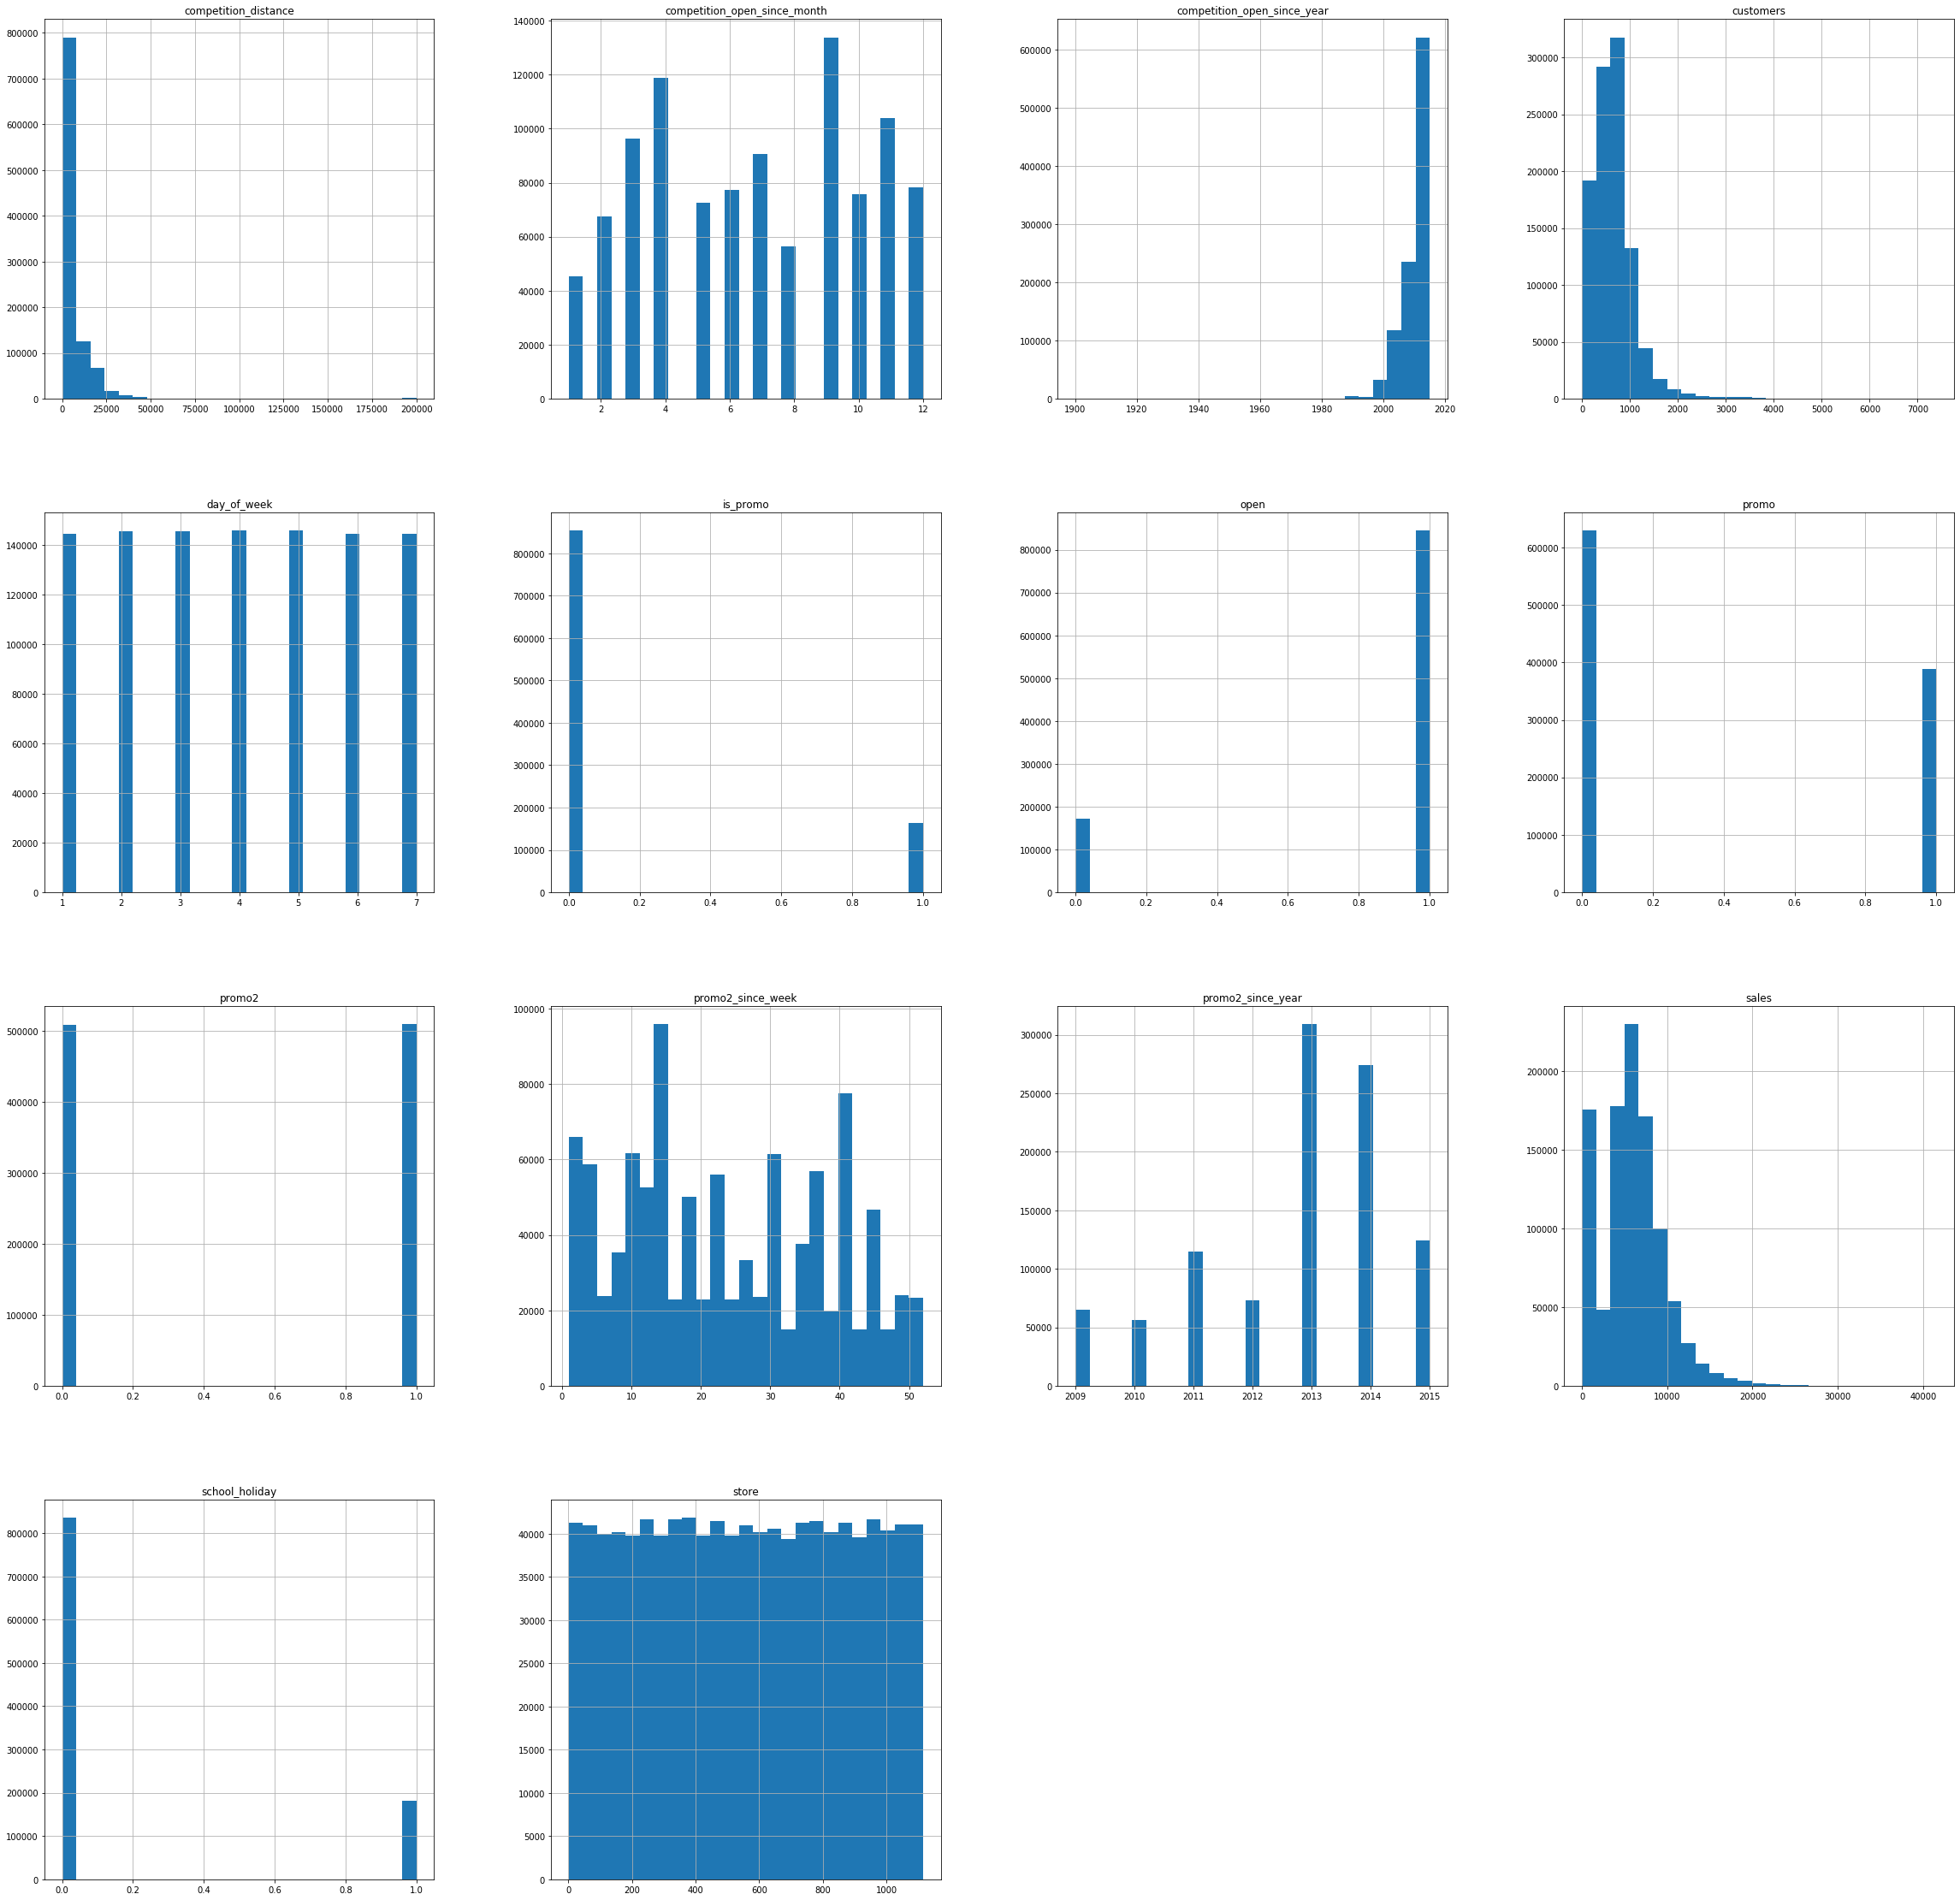

In [34]:
num_attributes.hist(figsize = (40,40), bins = 25);

### 4.1.3. Categorical Variable

In [35]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

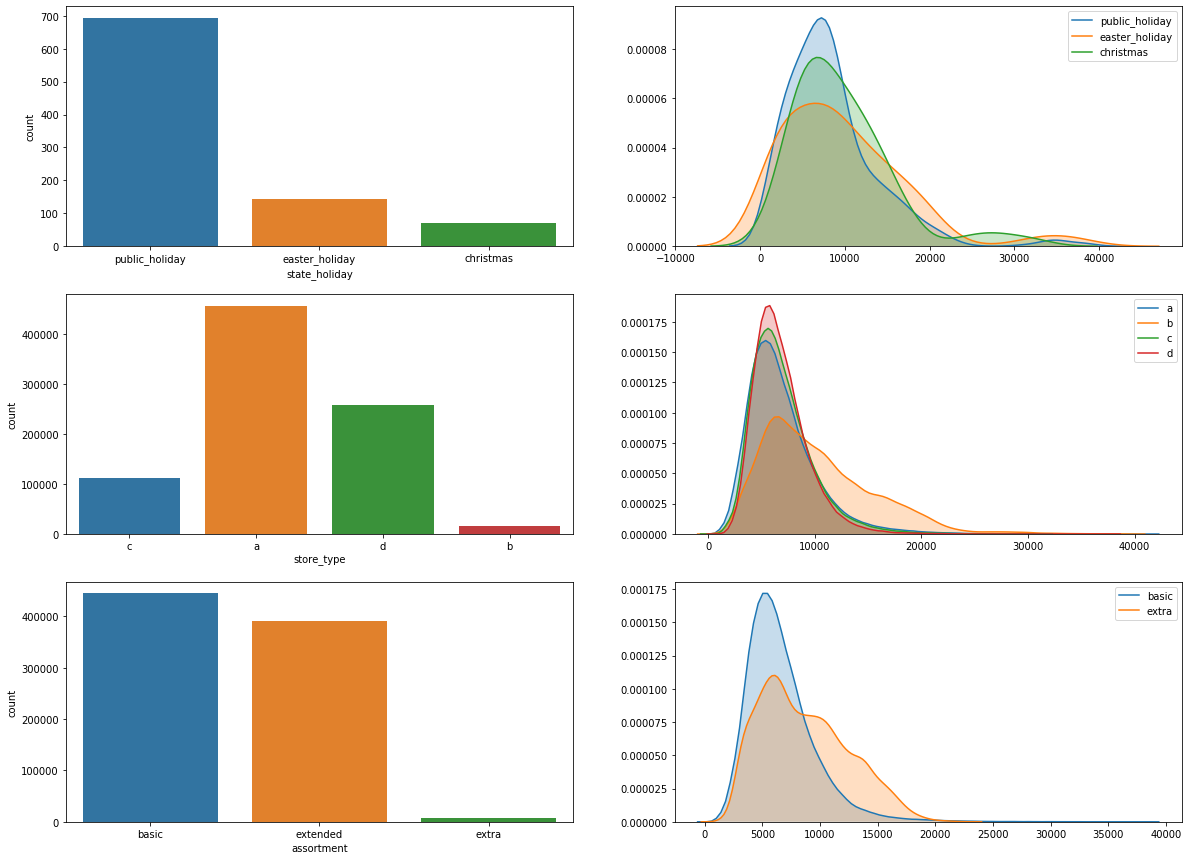

In [37]:
#state_holiday
plt.figure(figsize = (20,15))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label  = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label = 'extend', shade = True)

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.  

**False.** - Lojas com maior sortimentos vendem MENOS.

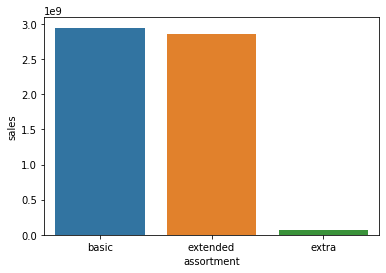

<Figure size 1080x504 with 0 Axes>

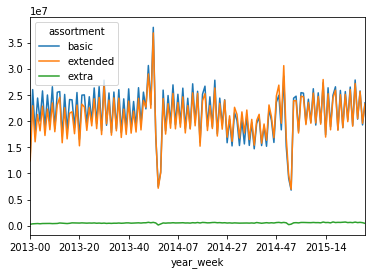

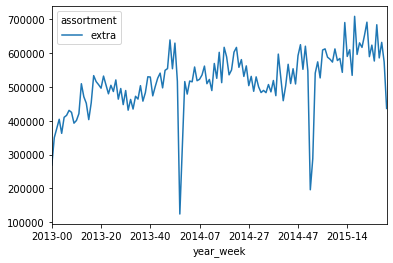

In [38]:
aux2 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux2);

plt.figure(figsize = (15,7))
aux3 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux3.pivot(index = 'year_week',columns = 'assortment', values = 'sales').plot()

aux4 = aux3[aux3['assortment'] == 'extra']
aux4.pivot(index= 'year_week', columns= 'assortment', values= 'sales').plot()

In [39]:
aux4

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061
...,...,...,...
398,2015-26,extra,684180
401,2015-27,extra,586036
404,2015-28,extra,632017
407,2015-29,extra,574020


### H2. Lojas com competidores mais próximos deveriam vender menos.

**Falsa** Lojas com competidores mais próximos vendem mais.

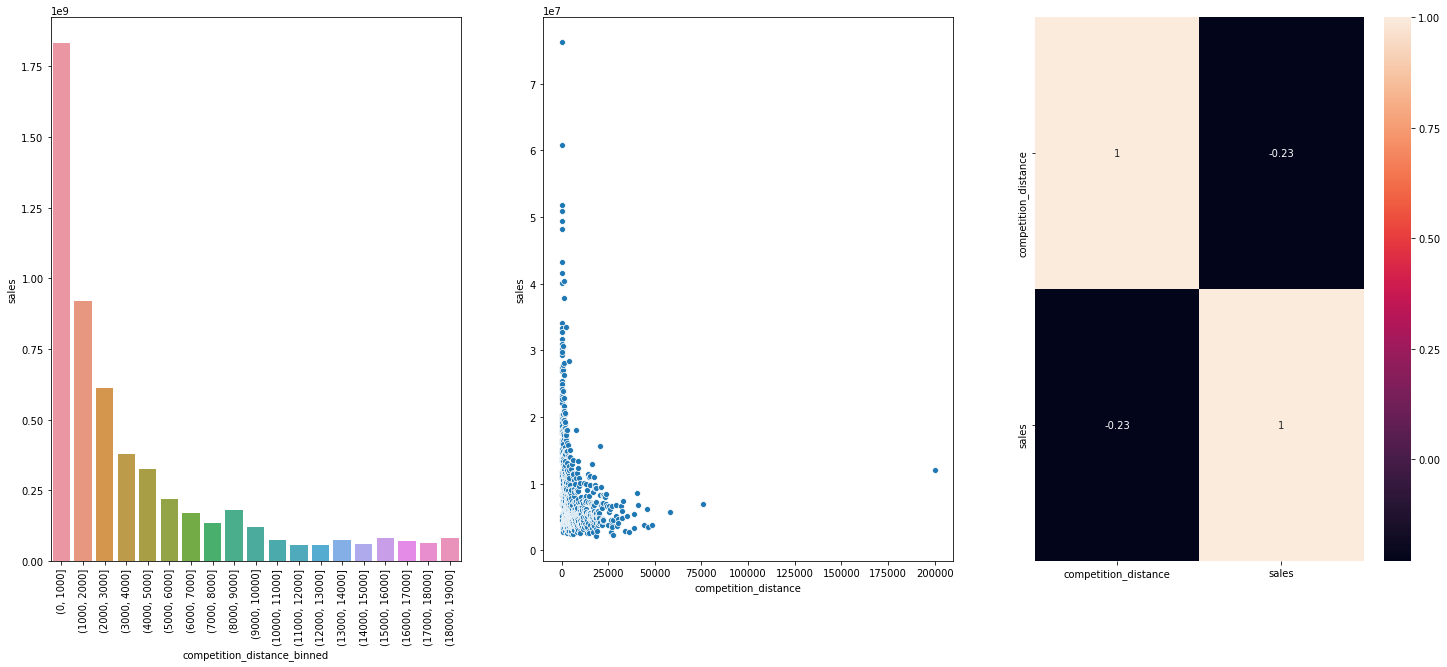

In [40]:
plt.figure(figsize = (25,10))
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby("competition_distance_binned").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='competition_distance_binned',y='sales',data = aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H3. Lojas com competidores à mais tempo deveriam vender menos.

**Falsa** Lojas com competidores a mais tempo vendem menos

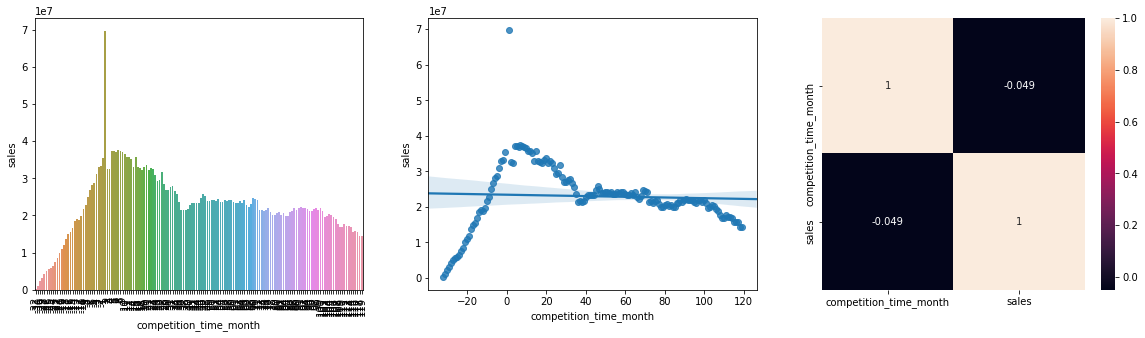

In [41]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y ='sales', data = aux2)


plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method = 'pearson'), annot = True)

### H4. Lojas com promoções ativas durante mais tempo deveriam vender mais.

**Falsa** Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

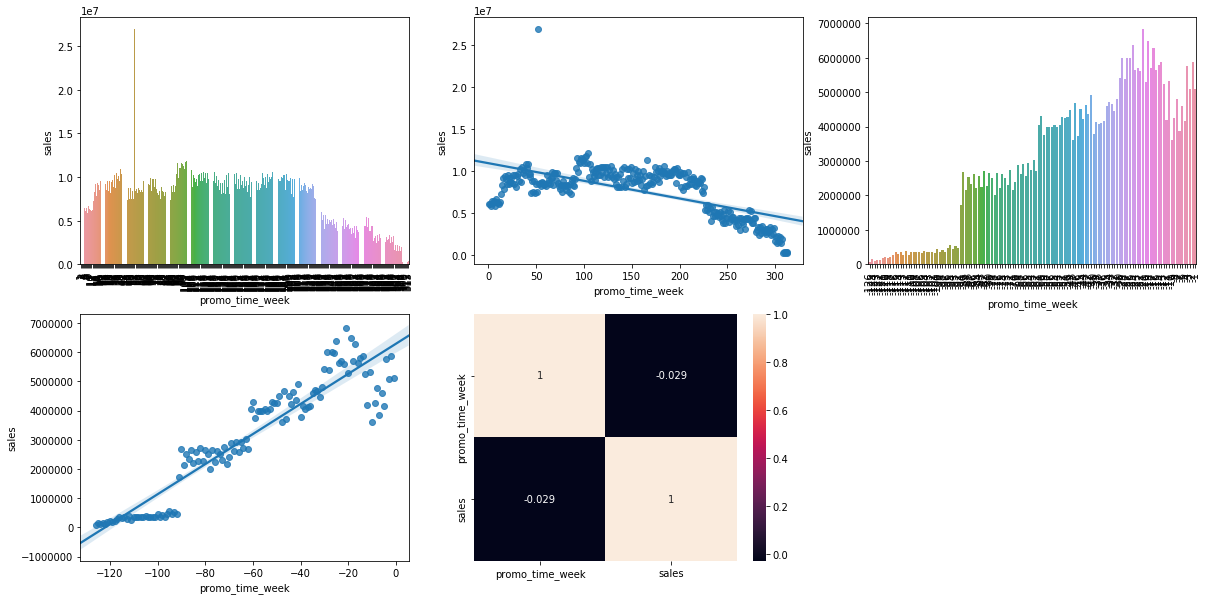

In [42]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize = (20,10))
plt.subplot(2,3,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90);

plt.subplot(2,3,2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(2,3,3)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90);

plt.subplot(2,3,4)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)


plt.subplot(2,3,5)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais<s>

### H6. Lojas com mais dias consecutivos de promoção deveriam vender mais.

**Falsa** Lojas com mais promoções consecutivas vendem menos

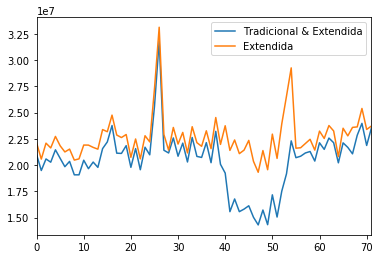

In [43]:

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby("year_week").sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels = ['Tradicional & Extendida','Extendida'])

### H7.  Lojas abertas durante o feriado de natal deveriam vender mais.

**Falsa** Lojas abertas no feriado de natal vendem menos.

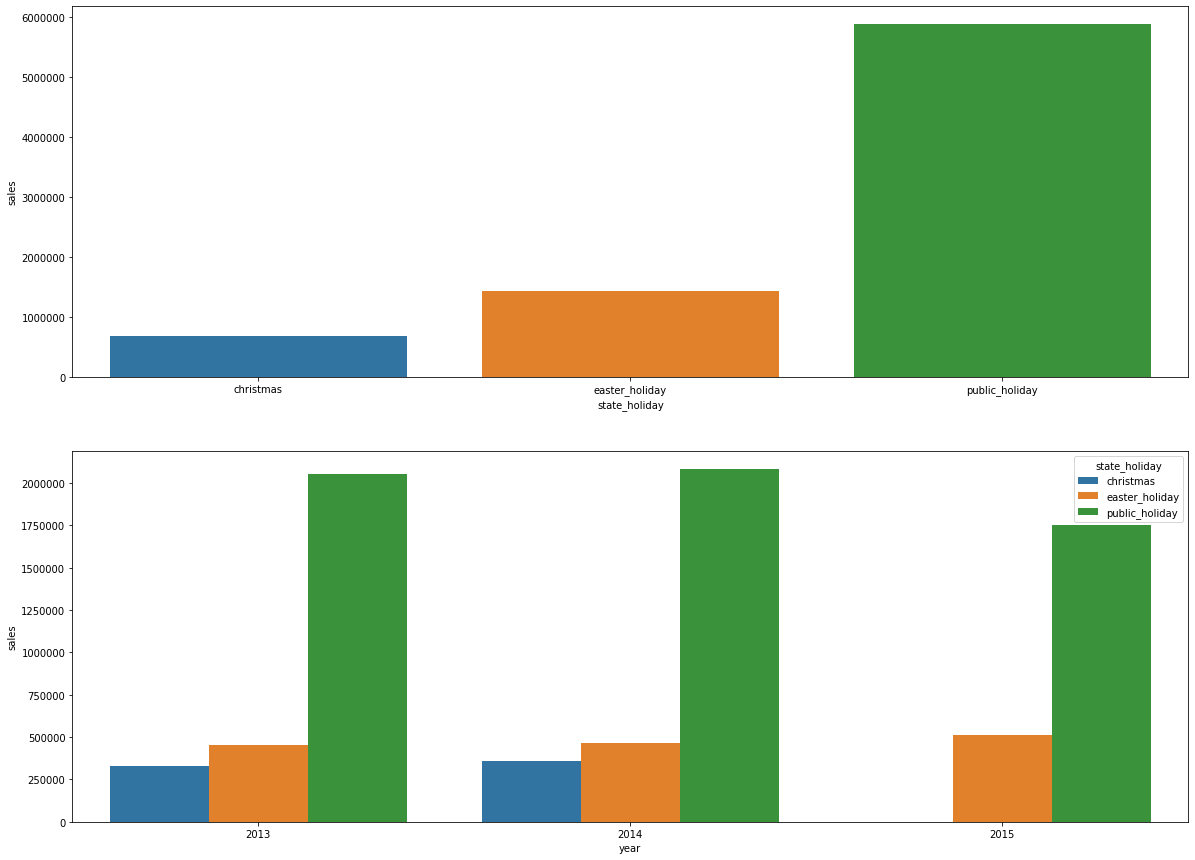

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby("state_holiday").sum().reset_index()

plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
sns.barplot(x = 'state_holiday',y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2)

### H8. Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem menos ao longo dos anos


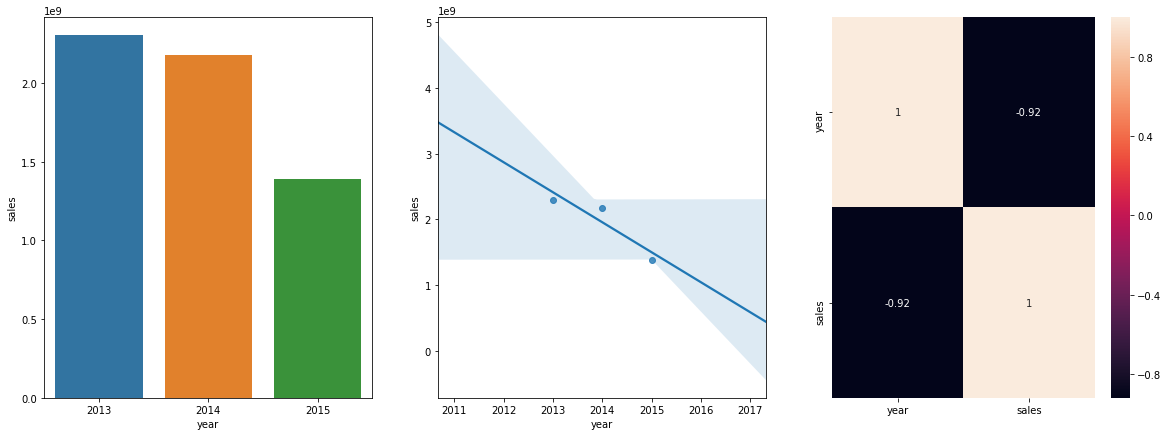

In [45]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** Lojas vendem menos no segundo semestre do ano

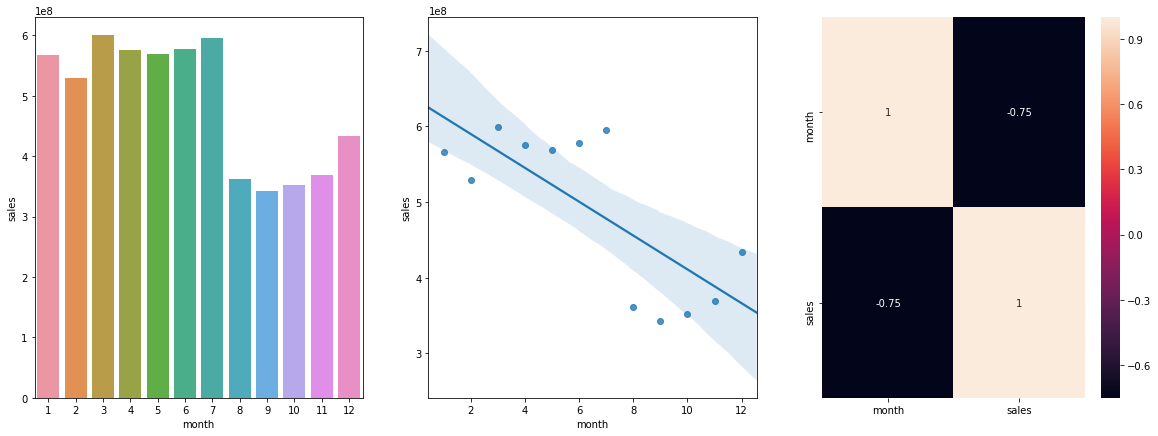

In [46]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**Verdadeiro**. As lojas vendem mais após os 10 primeiros dias de cada mês


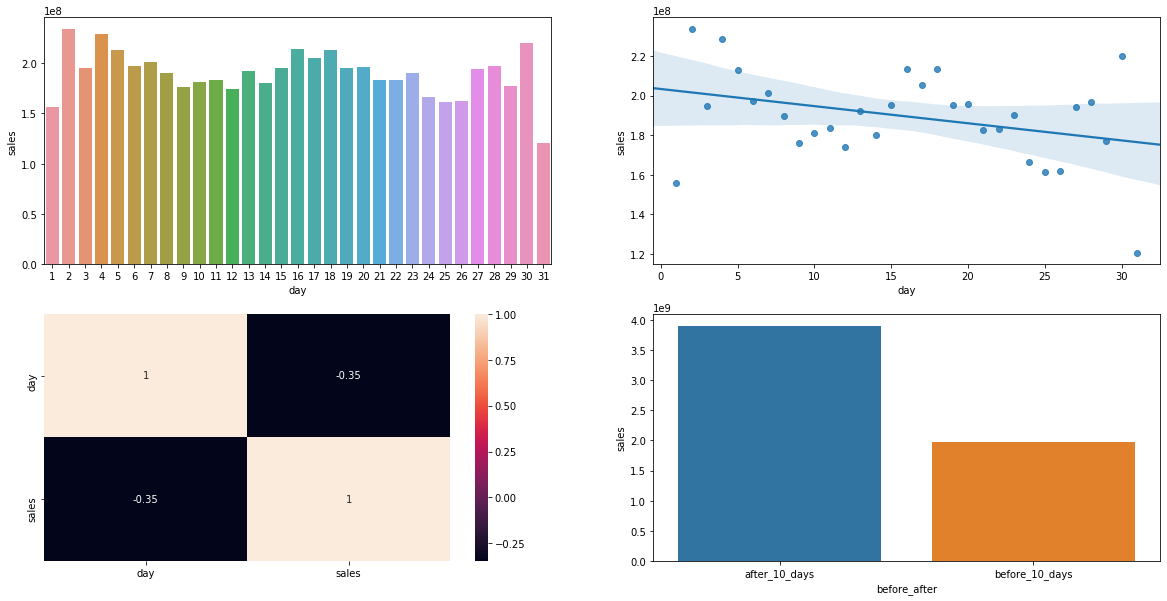

In [47]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x:"before_10_days" if x <= 10 else "after_10_days")
aux2 = aux1[['before_after','sales']].groupby("before_after").sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2)

### H11. Lojas deveriam vender menos aos finais de semana.

**Verdadeiro** Lojas vendem menos aos finais de semana

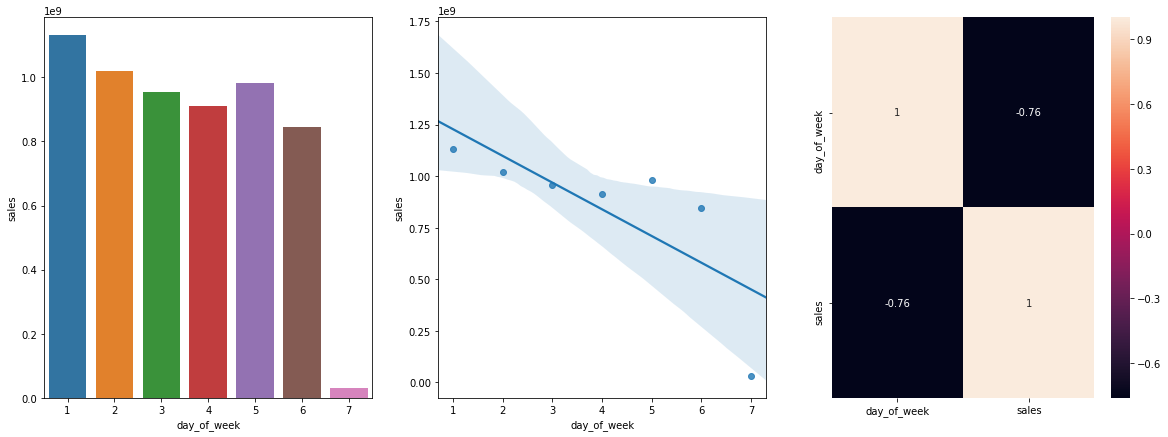

In [48]:
aux1 = df4[['day_of_week','sales']].groupby("day_of_week").sum().reset_index()

plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot = True )

### H12. Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

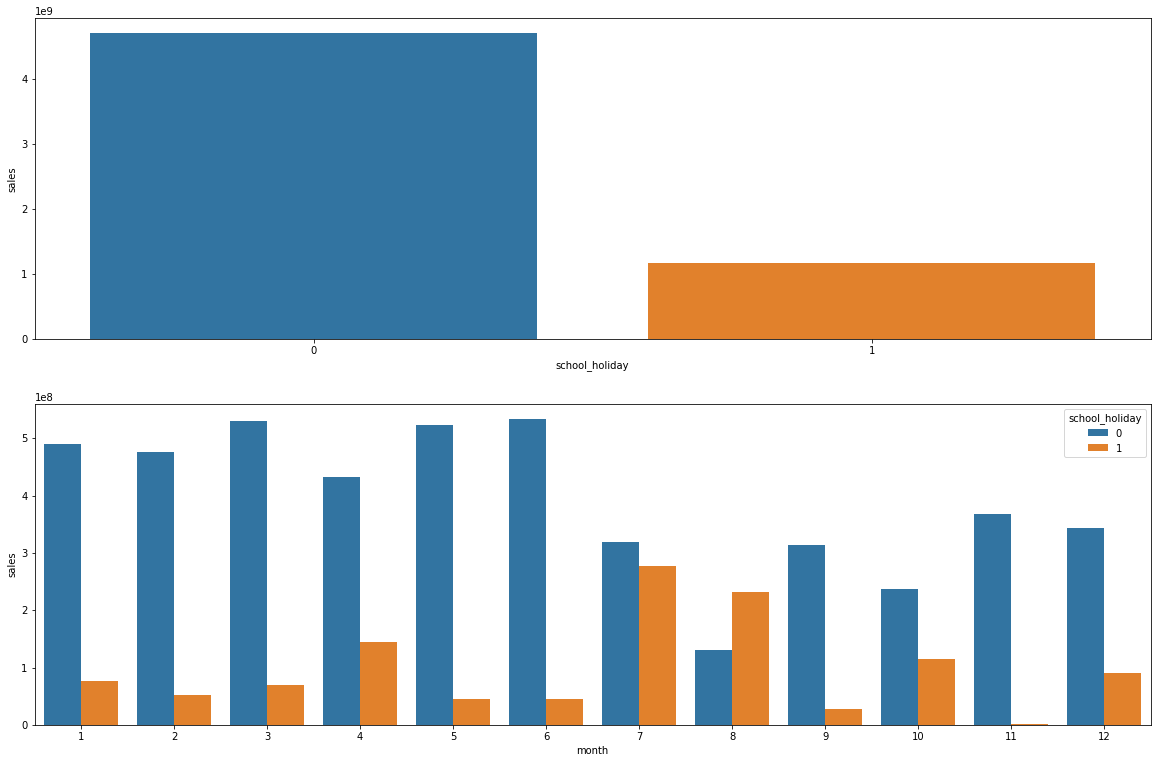

In [49]:
plt.figure(figsize = (20,13))

plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday',y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month',y = 'sales', hue = 'school_holiday', data = aux2)

### 4.2.1 Resumo das Hipóteses

In [50]:
from tabulate import tabulate

In [51]:
tab = [['HIPOTESES','CONCLUSAO','RELEVANCIA'],
      ['H1','Falsa','Baixa'],
      ['H2','Falsa','Media'],
      ['H3','Falsa','Media'],
      ['H4','Falsa','Baixa'],
      ['H5', '-','-'],
      ['H6','Falsa','Baixa'],
      ['H7','Falsa','Media'],
      ['H8','Falsa','Alta'],
      ['H9','Falsa','Alta'],
      ['H10','Verdadeira','Alta'],
      ['H11','Verdadeira','Alta'],
      ['H12','Verdadeira','Baixa']]

print(tabulate(tab, headers = 'firstrow'))

HIPOTESES    CONCLUSAO    RELEVANCIA
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

Por quê fazer a análise multivariada?

Os algoritmos de Machine Learning seguem algumas premissas,por exemplo, a teoria da Navalha de Ockham que garante o aprendizado dos modelo, a teoria diz o seguinte:

- Se você tiver vários modelos para escolher, você deve escolher o de menor complexidade pois irá generalizar melhor. 
- Algoritmos com alta dimensionalidade, irá pussuir um modelo complexo, portanto, retiramos variáveis(features).

Utilizamos da álgebra linear, os conceitos de dependência linear, ou seja, vamos supor que tempos duas colunas que sejam linearmente dependentes, ou seja, cuja influência no problema sejam semelhantes, podemos tirar uma que o efeito irá ser mantido. Para encontrar isso, podemos olhar a correlação entre as variáveis é uma alternativa para que possamos reduzir a dimensionalidade do nosso dataset.

### 4.3.1. Numerical Attributes

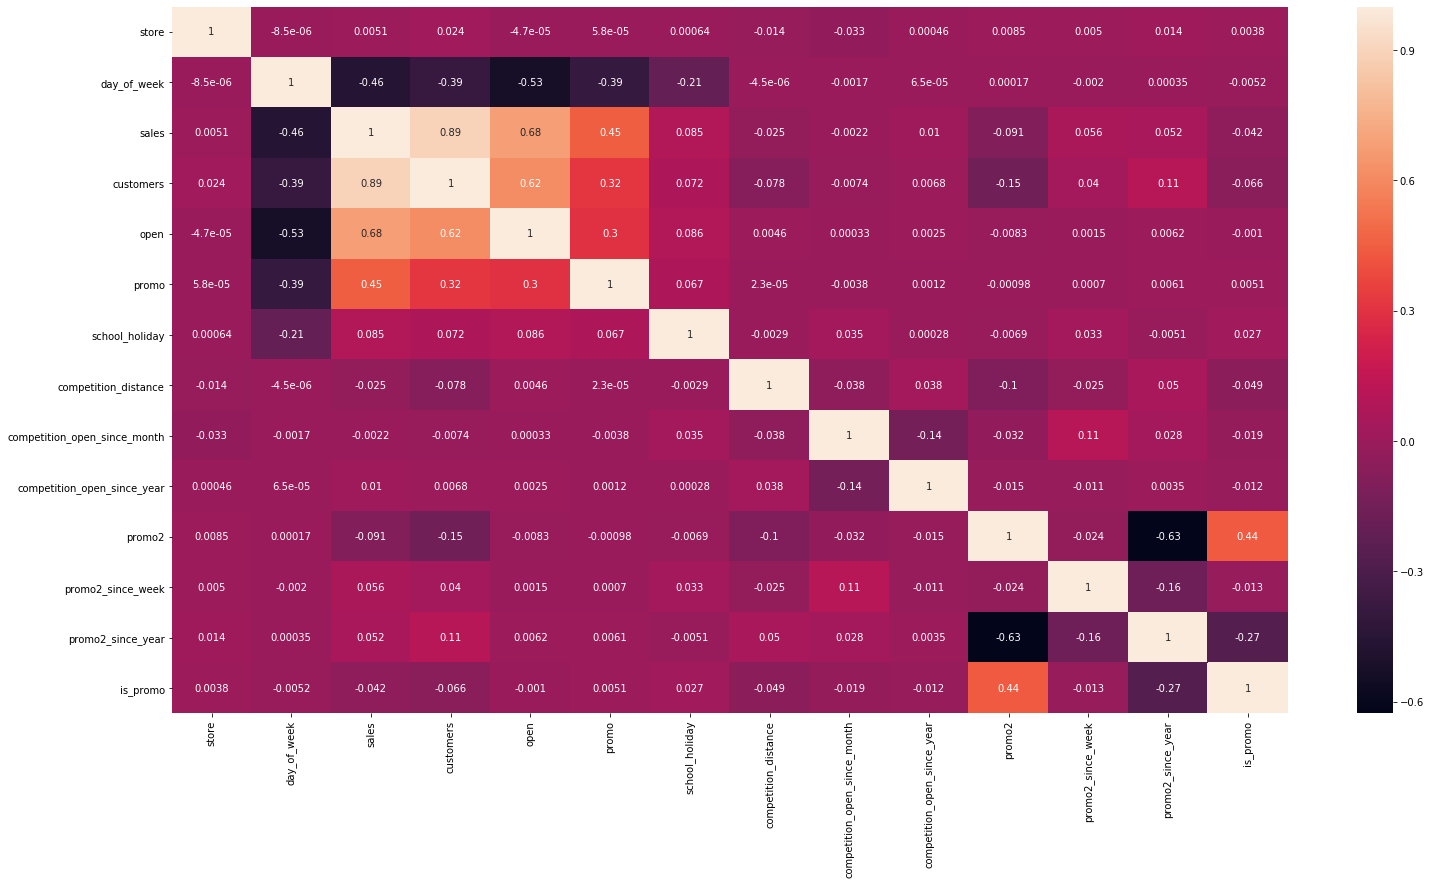

In [52]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize = (25,13))
sns.heatmap(correlation, annot = True)

### 4.3.2 Categorical Attributes

In [53]:
from scipy import stats

In [54]:
a = df4.select_dtypes(include = 'object')

Para verificar a correlação entre as variáveis categóricas, utilizaremos o método de "Cramér's V", diferentemente do que utilizamos para realizar a correlação entre as variáveis numéricas, utilizando o método de "pearson". Conforme a equação abaixo:

In [55]:
Image("img/CramerV.png")

FileNotFoundError: No such file or directory: 'img/CramerV.png'

FileNotFoundError: No such file or directory: 'img/CramerV.png'

<IPython.core.display.Image object>

In [56]:
#Tabela de contigência

cm = pd.crosstab( a['state_holiday'], a['store_type']).values

In [57]:
chi2 = stats.chi2_contingency(cm) 
chi2

(12792.159524019908,
 0.0,
 9,
 array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
        [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
        [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
        [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

- 12792.159524019908 = Teste do ChiSquared baseado em Pearson
- 0.0 = p-valor
- 9 = N° do grau de liberdade
- array = Tabela de frequência 

**Estamos mais interessados no primeiro valor para implementar o Cramér's V**

In [58]:
chi2 = stats.chi2_contingency(cm)[0] 

n = cm.sum()

r , k = cm.shape

In [59]:
#Implementando o método de Cramér's V

v = np.sqrt( (chi2/n) / (min( k-1, r-1 )))

In [60]:
v

0.07106457093267678

Diferentemente do coeficiente de Pearson que vai de -1 a 1, o Cramér's V vai de 0 a 1. Ou seja, não há correlação negativa em variáveis categóricas. Podemos criar uma função para aplicar a todas as outras colunas.

É necessário lembrar que precisaremos modificar um pouco a nossa função para que se ajuste de fato ao nosso modelo, pois o Cramer's V possui um viés muito alto podendo superestimar a nossa análise, sendo necessário realizar a correção. Observe a fórmula abaixo.

In [61]:
Image("img/CramerV2.png")

FileNotFoundError: No such file or directory: 'img/CramerV2.png'

FileNotFoundError: No such file or directory: 'img/CramerV2.png'

<IPython.core.display.Image object>

In [62]:
#Construindo a função v de cramer
def cramer_v(x,y):
   
    cm = pd.crosstab(x,y).values
    r, k = cm.shape
    n = cm.sum()
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2 /(n-1) 
    rcorr = r - (r-1)**2 /(n-1)
   
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 )))

In [63]:
#Chamando a função

cramer_v(a['state_holiday'],a['store_type'])

0.07106469715258833

In [64]:
#construindo a matrix

a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

#final dataset
d = d.set_index(d.columns)

In [65]:
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


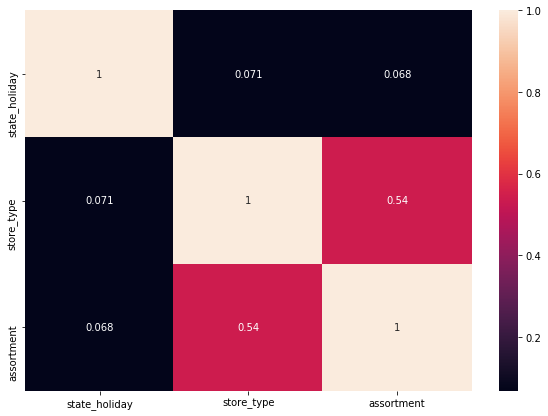

In [66]:
#Plotando a matrix de correlação com o seaborn
plt.figure(figsize = (10,7))
sns.heatmap(d, annot = True)

# 5.0. PREPARAÇÃO DOS DADOS

In [67]:
df5 = df4.copy()

A aprendizado da maioria dos nosso algoritmos de Machine Learning é facilitado quando trabalhamos com dados numéricos e também com variáveis que estão na mesma escala, pois, utilizam tais algoritmos utilizam técnicas de otimização que necessitam de diversas operação como derivadas, por exemplo. Portanto, essa seção irá focar em preparar nossos dados para que estejam adequados para realizar o treinamento do nosso modelo.

## 5.1. Normalização

A normalização consiste em rescalar o centro de nossas variáveis para 0 com um desvio padrão de 1. Tal operação pode ser feita a partir da fórmula abaixo:

In [68]:
Image("img/normalizacao.png")

FileNotFoundError: No such file or directory: 'img/normalizacao.png'

FileNotFoundError: No such file or directory: 'img/normalizacao.png'

<IPython.core.display.Image object>

Como não possuímos variáveis cuja distribuição se aproxima da Distribuição Gaussiana(Normal), não iremos efetuar tal operação para não forçar um comportamento que não queremos. Tentaremos fazer um rescaling que funciona muito bem para variáveis que não pussuem tal distribuição.

## 5.2. Rescaling

Diferentemente da normalização, o rescaling se comporta muito bem quando lidamos com variáveis que não possuem distribuições normais(gaussianas). Tem como objetivo rescalar para um intervalo de 0 a 1. Observe a fórmula abaixo:

In [69]:
Image("img/rescaling.png")

FileNotFoundError: No such file or directory: 'img/rescaling.png'

FileNotFoundError: No such file or directory: 'img/rescaling.png'

<IPython.core.display.Image object>

In [70]:
a = df5.select_dtypes(include = ['int64','float64','int32'])

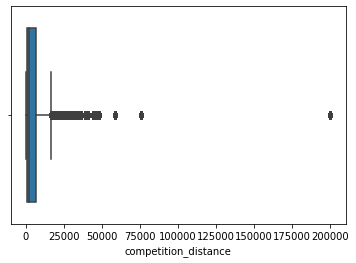

In [71]:
#competition_distance
sns.boxplot(df5['competition_distance'])

**Como o rescaling é super sensível à outliers e nossa coluna possui, iremos utilizar o RobustScaler do sklearn. Esse método é um pouco diferente pois, ao invés de dividir pelo range da coluna, ou seja (Xmáx - Xmin) ele irá efetuar a operação de diferença entre quartis (Quartil3 - Quartil1), excluindo portando os outliers.**

In [72]:
Image("img/robustscaler.png")

FileNotFoundError: No such file or directory: 'img/robustscaler.png'

FileNotFoundError: No such file or directory: 'img/robustscaler.png'

<IPython.core.display.Image object>

In [73]:
#competition_distance
from sklearn.preprocessing import RobustScaler, MinMaxScaler

rs = RobustScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

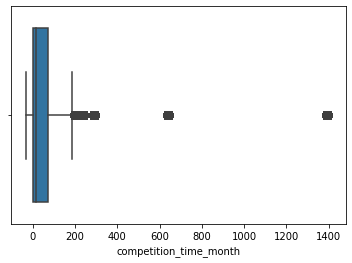

In [74]:
#competition time month
sns.boxplot(df5['competition_time_month'])

In [75]:
#Competition_time_month
mms = MinMaxScaler()

df5['competition_time_month'] = mms.fit_transform(df5[['competition_time_month']].values)

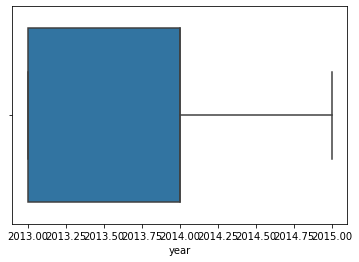

In [76]:
#year
sns.boxplot(df5['year'])

In [77]:
#year
df5['year'] = mms.fit_transform(df5[['year']].values)

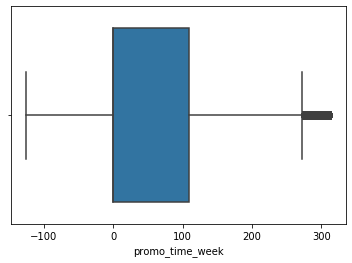

In [78]:
#promo_time_week
sns.boxplot(df5.promo_time_week)

In [79]:
#Promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## 5.3 Transformação

### 5.3.1. Encoding

In [80]:
#state_holiday - OneHotEncoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday']) 

#store_type - LabelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - OrdinalEncoding
assortment_dict = {'basic':1,"extra":2,"extended":3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [81]:
df5['sales'] = np.log1p(df5['sales'])

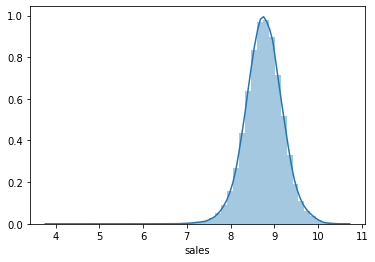

In [82]:
sns.distplot(df5['sales']);

### 5.3.3. Nature Transformation

In [83]:
#day_of_week - natureza cíclica
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#month - natureza cíclica
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2. * np.pi/12 ) ) )

#day - natureza cíclica
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2*np.pi/30)))

#week_of_year - natureza cíclica
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2*np.pi/52)))

In [84]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [85]:
df6 = df5.copy()

## 6.1. Split Dataframe into training and test dataset

In [86]:
#deletando colunas que a partir delas foram derivadas outras features
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [87]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7*6)

Timestamp('2015-06-19 00:00:00')

In [88]:
#training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

In [89]:
print("Train Rage = ",X_train['date'].min(),X_train['date'].max())

print("\n")

print("Test Range = ",X_test['date'].min(),X_test['date'].max())


Train Rage =  2013-01-01 00:00:00 2015-06-18 00:00:00


Test Range =  2015-06-20 00:00:00 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [90]:
#training and test dataset for boruta
#X_train_n = X_train.drop(['date','sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

#define randomforestRegressor
#rf = RandomForestRegressor(n_jobs = -1)


#define boruta
#boruta =  BorutaPy(rf , n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n,y_train_n)

### 6.2.1 Best Features for Boruta

In [91]:
#cols_selected = boruta.support_.tolist()

#best_ features
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

NameError: name 'boruta' is not defined

In [92]:
#cols_selected_boruta

## 6.3. Manual Feature Selection

Apesar de que automaticamente nosso algoritmo seleciona as variáveis importantes, optei por acrescentar as variáveis "month_sin", "week_of_year_sin" e "day_of_week_sin". Através da nossa análise exploratória no tópico 4, pudemos compreender o comportamento delas e identificar a partir do nosso conhecimento de negócio, possíveis variáveis relevantes para o modelo. Portanto, apesar do algoritmo ser de extrema importância para seleção das features, não anula a nossa opnião acerca do problema que estamos trabalhando.

In [93]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',   
     'week_of_year_cos'
]

#columns to add

feat_to_add =  ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.extend(feat_to_add)

In [94]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. MACHINE LEARNING MODELLING

In [95]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [96]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how = 'left', on ='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1366.128351,0.121137,1854.263316


## 7.2 Linear Regression Model

In [97]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression:', np.expm1(y_test),np.expm1(yhat_lr))
lr_result

TypeError: invalid type promotion

### 7.2.1. Linear Regression Model - Cross Validation

In [ ]:
#cross_validation(x_training,kfold, model_name, model, verbose = False):
lr_result_cv = cross_validation(x_training, 5,'Linear Regression', lr)
lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

In [ ]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train,y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso:', np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

### 7.3.1. Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation(x_training, 5,'Lasso',lrr,verbose = False)
lrr_result_cv

## 7.4. Random Forest Regressor

In [125]:
#model
#rf = RandomForestRegressor(n_estimators = 100,n_jobs = -1, random_state = 42).fit(x_train,y_train)

#prediction
#yhat_rf = rf.predict(x_test)

#performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf))
#rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.419027,0.100217,1014.757679


### 7.4.1. Random Forest Regressor - Cross Validation

In [192]:
#rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',rf,verbose = True)
#rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.55 +/- 217.1,0.12 +/- 0.02,1254.18 +/- 316.23


## 7.5. XGBoost Regressor

In [ ]:
import xgboost as xgb

In [ ]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01, 
                             max_dept
                             h = 10,
                             subsample = 0.7,
                             colsample_bytee = 0.9).fit(x_train,y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

### 7.5.1. XGBosst Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training,5,'XGBoost Regressor',model_xgb, verbose = True)
xgb_result_cv

## 7.6. Compare Model's Performance

In [ ]:
#adding date and sale
cols_full = cols_selected_boruta.copy()
cols_full.extend(feat_to_add )

x_training = X_train[cols_full]

### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,xgb_result])
modelling_result.sort_values("RMSE")

In [ ]:
x_training.head()

### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv]) 

In [198]:
#Real performance
modelling_result_cv.sort_values("RMSE CV")

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.55 +/- 217.1,0.12 +/- 0.02,1254.18 +/- 316.23
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

import random
import warnings

warnings.filterwarnings('ignore')

param = {
    'n_estimators': [1500,1700,2500,3000,3500],
    'max_depth': [3,5,9]
}


MAX_EVAL = 10

final_result = pd.DataFrame()



for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    
    #model
    rf = RandomForestRegressor(n_estimators = hp['n_estimators'],
                               n_jobs = -1, 
                               max_depth = hp['max_depth'],
                               random_state = 42)

    
    #performance - cross_validation(x_training,kfold,model_name,model,verbose = False)
    
    result = cross_validation(x_training,5, 'Random Forest Regressor', rf,verbose = False)
    final_result = pd.concat([final_result,result])
    
    
return final_result

## 8.2. Final Model

 import pickle

pickle.dump(rf_result_cv, open("C:\ProjetosDataScience\DataScienceProducao\Entendendo o Negócio/model_rossmann.pkv", 'wb'))

In [ ]:
#model
rf_tuned = RandomForestRegressor(n_estimators = 1,
                               n_jobs = -1, 
                               random_state = 42).fit(x_train,y_train)

#prediction
yhat_rf_tuned = rf_tuned.predict(x_test)


#performance
rf_result_tuned = ml_error("Random Forest Regressor", np.expm1(y_test),np.expm1(yhat_rf_tuned), verbose = True)
rf_result_tuned
    

In [228]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_rf))

0.10021727434128697

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

df9 =  X_test[cols_selected_boruta]
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_rf)

## 9.1. Business Performance

In [ ]:
#sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:"MAE"})
df9_aux2 = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0: "MAPE"})

In [ ]:
#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')


#scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df92.sort_values("MAPE", ascending = False).head()

In [ ]:
plt.figure(figsize = (15,7))
sns.scatterplot(x = 'store',y = 'MAPE', data = df92)

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {"index":"Scenario",0:"Values"})

df93['Values'] = df93['Values'].map("R${:,.2f}".format)
df93

## 9.3. Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

In [ ]:
plt.figure(figsize = (20,10 ))
plt.subplot(2,2,1)
sns.lineplot(x = 'date',y = 'sales', data = df9, label = 'SALES')
sns.lineplot(x = 'date',y = 'predictions', data = df9, label = 'PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = 'predictions', y = 'error', data = df9)